In [1]:
import sys
sys.path.insert(1, '../utils') # insert at 1, 0 is the script path (or '' in REPL)
import fem
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import pandas

font = {'family' : 'monospace',
        #'weight' : 'bold',
        'size'   : 20}
plt.rc('figure', figsize=(16,9))
plt.rc('font', **font)  # pass in the font dict as kwargs
plt.rc('lines', lw=2, markersize=13)

In [2]:
rho = 7850 # kg/m3
E = 210e9    #Pa
L_total = 1 #m
A = 10e-4 #m2
I = 10e-8 #m2

In [3]:
Ne = 27
Nn = Ne+1
dL = L_total/Ne
glxn = 2
dimension = 1
MC = np.array([(i, i+1) for i in range(Ne)])
MN = np.array([(i*dL, (i+1)*dL) for i in range(Nn)])
MC

Ees = np.array(Ne*[E]) # Array de módulos elásticos para cada elemento
Aes = np.array(Ne*[A]) # Array de áreas para cada elemento

In [4]:
k_elemental = (E * I / dL ** 3) * np.array([[12, 6 * dL, -12, 6 * dL],
											[6 * dL, 4 * (dL ** 2), -6 * dL, 2 * (dL ** 2)],
											[-12, -6 * dL, 12, -6 * dL],
											[6 * dL, 2 * (dL ** 2), -6 * dL, 4 * (dL ** 2)]])

k_global = fem.global_matrix_ensemble(MN, MC, k_elemental, glxn)

In [5]:
Me = (rho*A*dL/420)*np.array([[156,   22*dL,     54,   -13*dL],
                         [22*dL,  4*dL**2,   13*dL, -3*dL**2],
                         [54,    13*dL,     156,  -22*dL],
                         [-13*dL, -3*dL**2, -22*dL,  4*dL**2]])


M_global = fem.global_matrix_ensemble(MN, MC, Me, glxn)

In [6]:
# s contiene los nodos con condiciones de vínculo en desplazamiento.
s = np.array([0,1])

# r contiene los nodos con condiciones de vínculo en fuerza. Es el complemento de "s".
r = fem.get_complementary_array(glxn*Nn, s) 

# Fr = np.zeros_like(r)

# "Us" con los valores de las condiciones de vínculo.
Us = np.zeros_like(s)

In [7]:
idxs = np.ix_(r,r)

omega_sq, V = linalg.eigh(k_global[idxs], M_global[idxs])
f = np.sqrt(omega_sq)/(2*np.pi)

In [8]:
V_complete = np.vstack([np.zeros((len(s), len(omega_sq))), V])

In [9]:
d = V_complete[0::2,:]
d = d/d[-1,:]

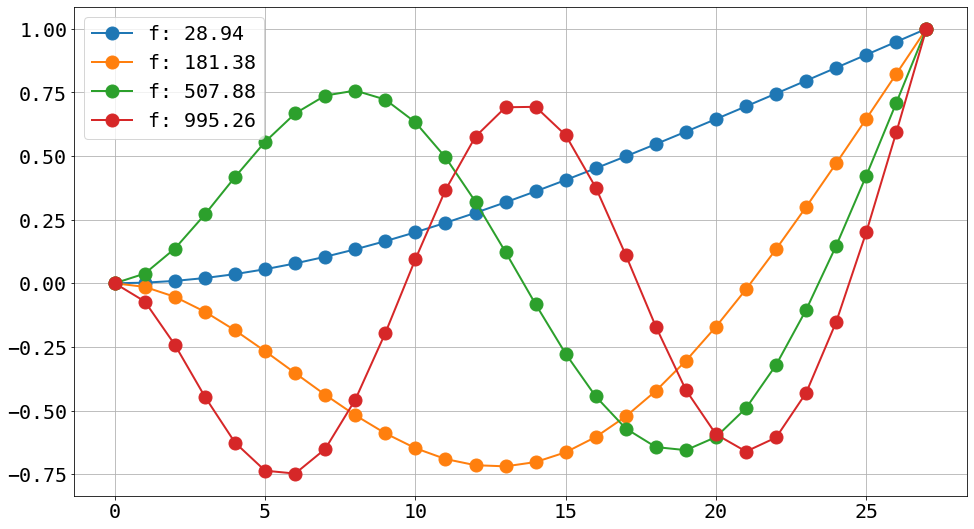

In [10]:
N = 4
for i in range(N):
    plt.plot(np.arange(Nn), d[:,i], 'o-', label= 'f: '+ str(round(f[i], 2)))
plt.grid()
plt.legend()

# Matriz concentrada

In [11]:
Me_c = (rho*A*dL/24)*np.array([  [12, 0, 0, 0],
                                [0, dL**2, 0, 0],
                                [0, 0, 12, 0],
                                [0, 0, 0, dL**2]])


M_global_c = fem.global_matrix_ensemble(MN, MC, Me_c, glxn)

In [13]:
idxs = np.ix_(r,r)

omega_sq_c, V_c = linalg.eigh(k_global[idxs], M_global_c[idxs])
f_c = np.sqrt(omega_sq_c)/(2*np.pi)

In [14]:
V_complete_c = np.vstack([np.zeros((len(s), len(omega_sq_c))), V_c])

In [15]:
d_c = V_complete_c[0::2,:]
d_c = d_c/d_c[-1,:]

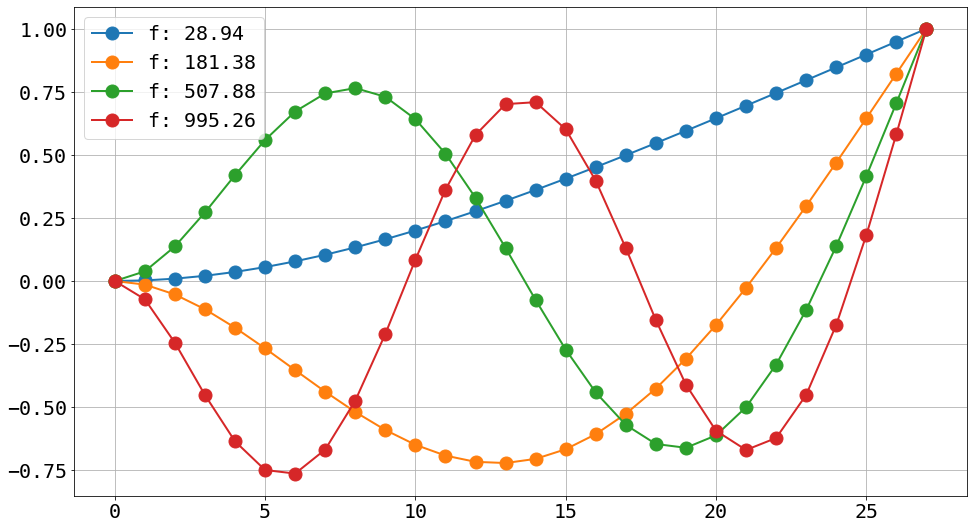

In [16]:
N = 4
for i in range(N):
    plt.plot(np.arange(Nn), d_c[:,i], 'o-', label= 'f: '+ str(round(f[i], 2)))
plt.grid()
plt.legend()

C:\Users\Pc\AppData\Local\Temp\ipykernel_16316\2234945037.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


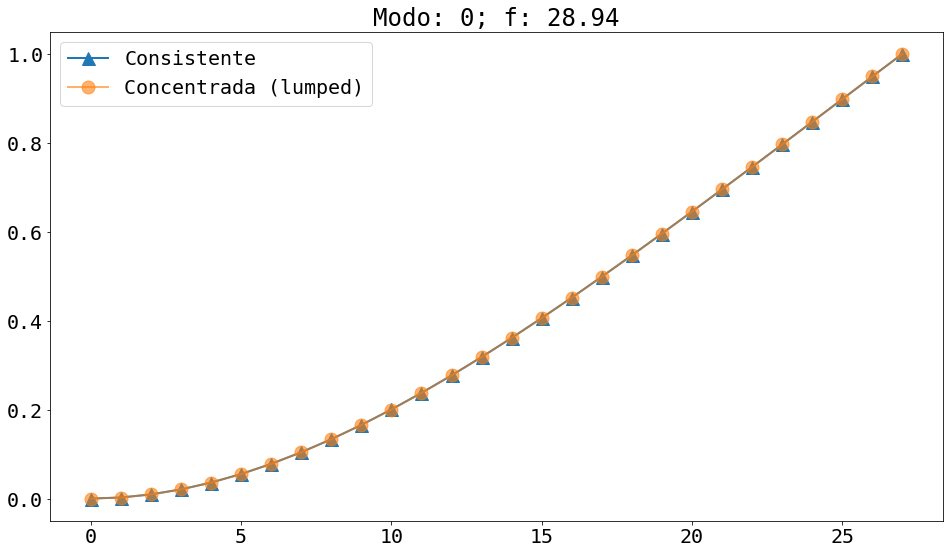

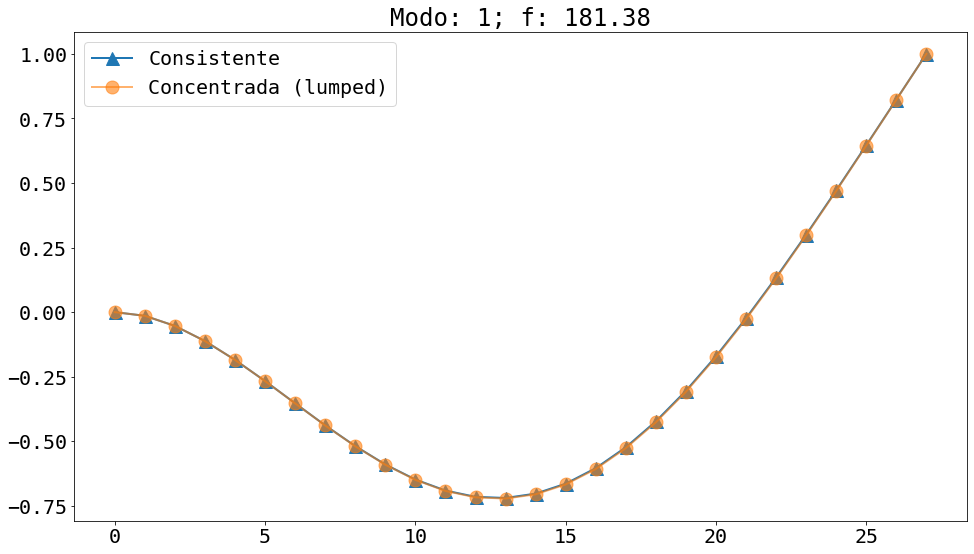

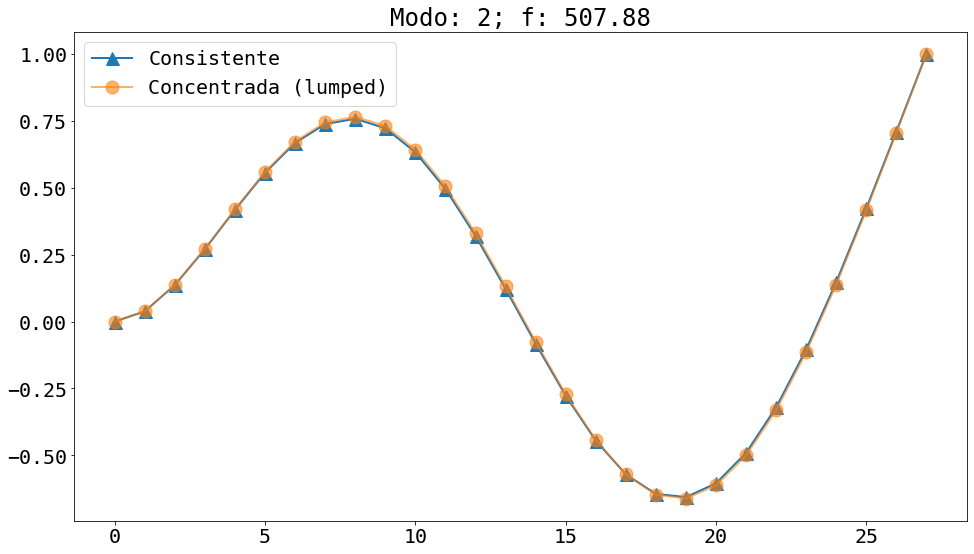

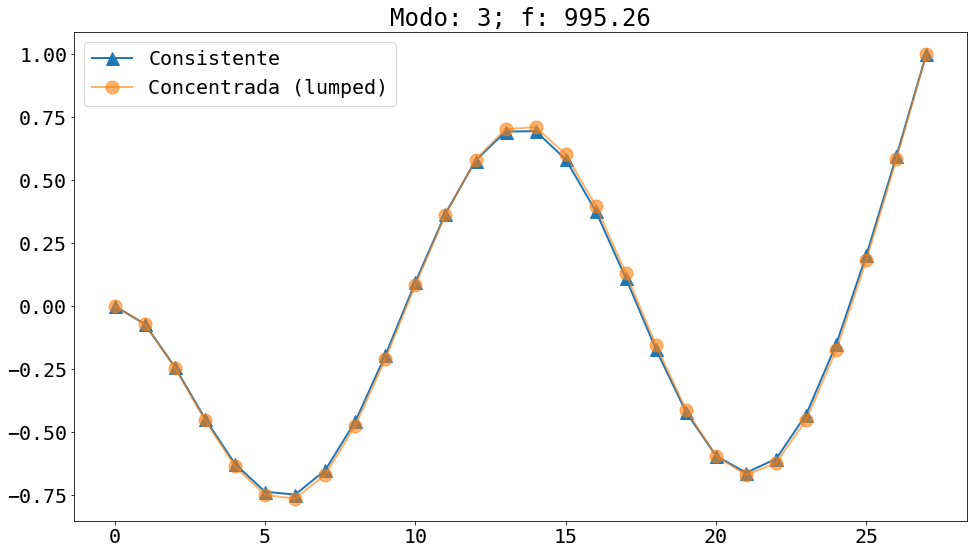

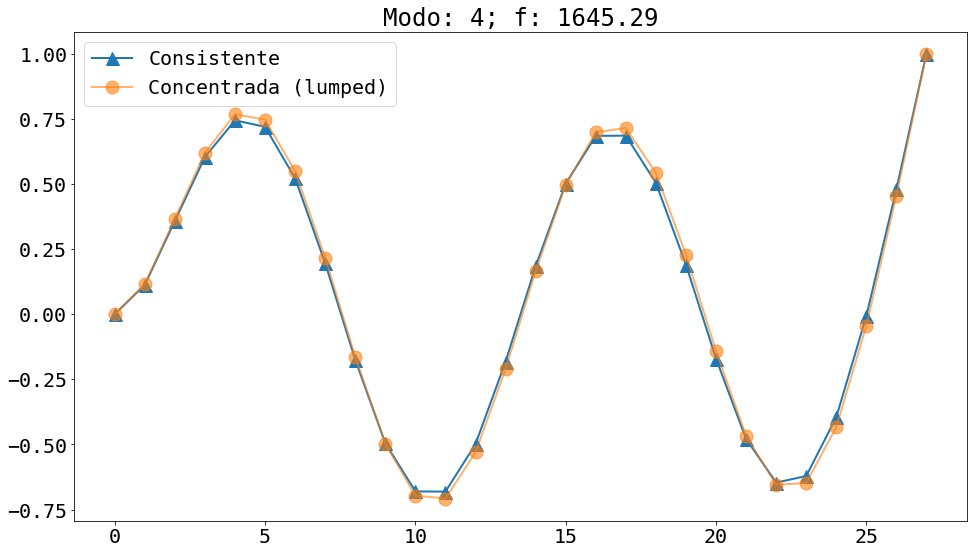

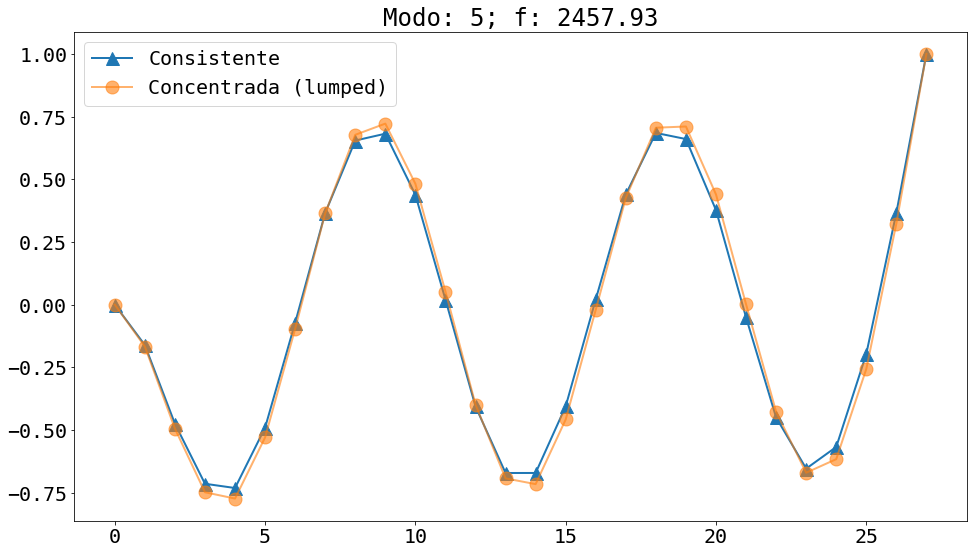

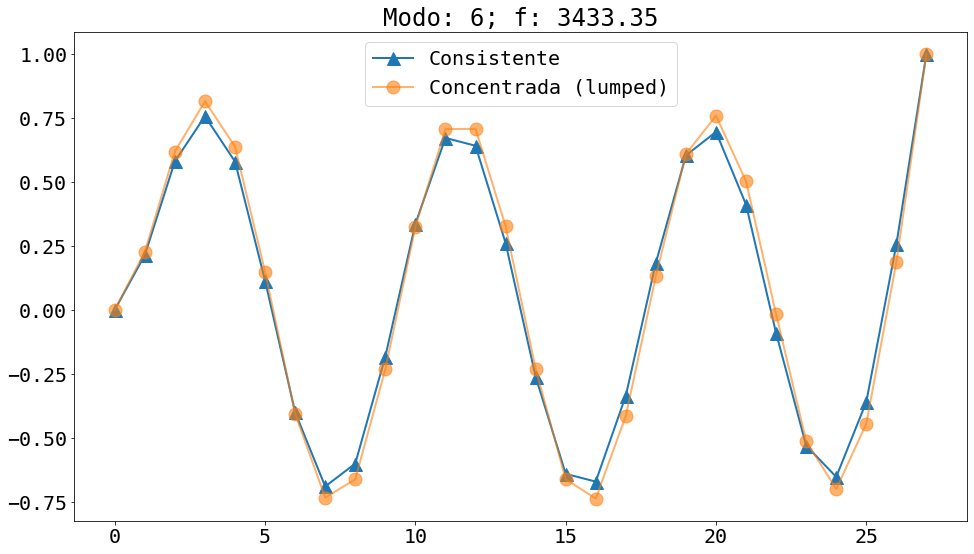

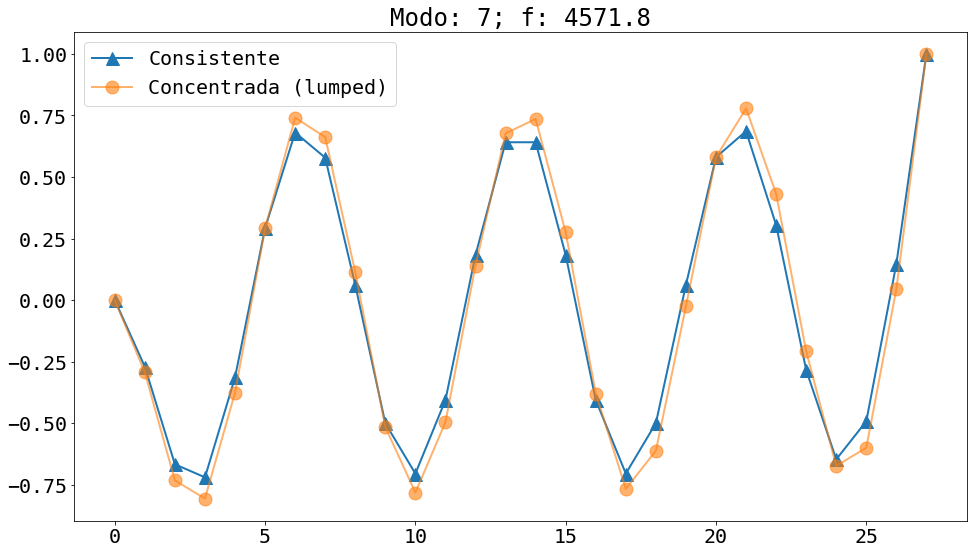

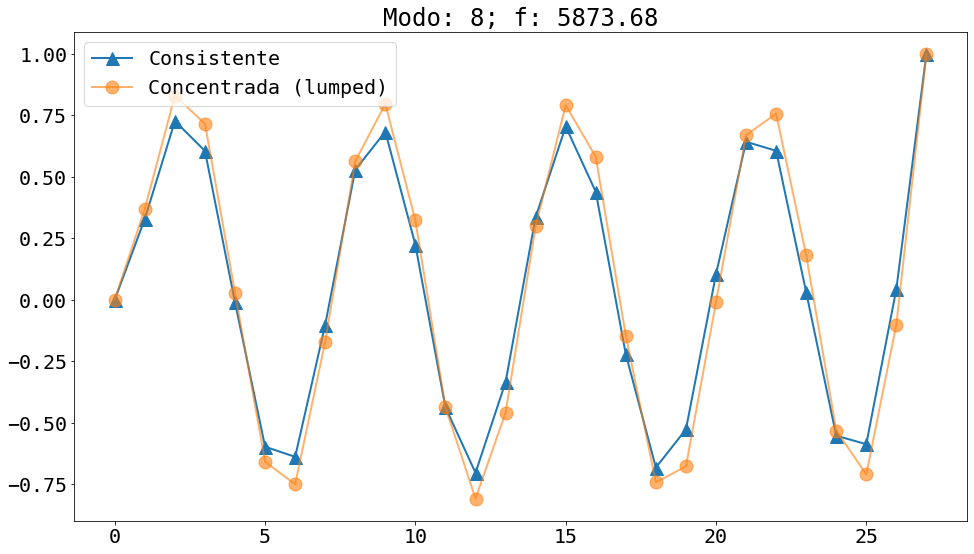

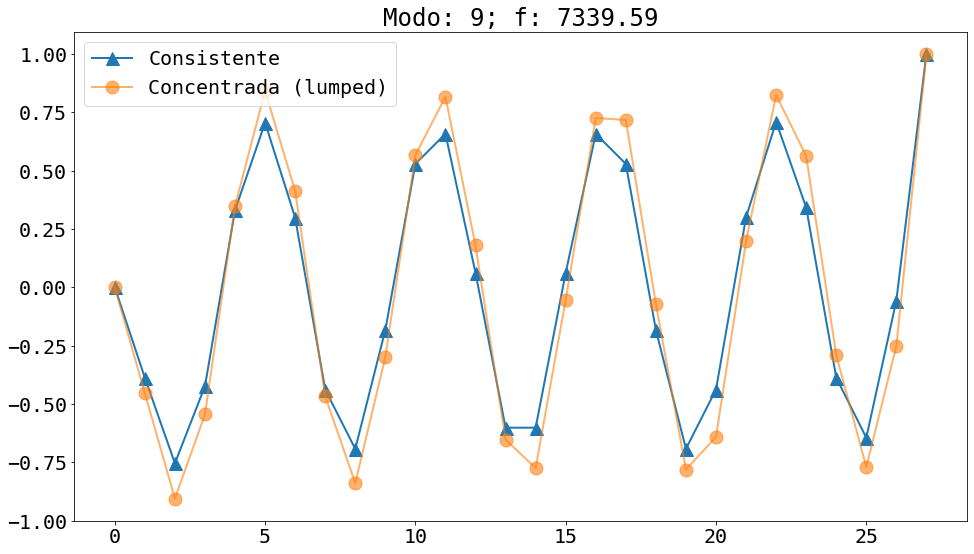

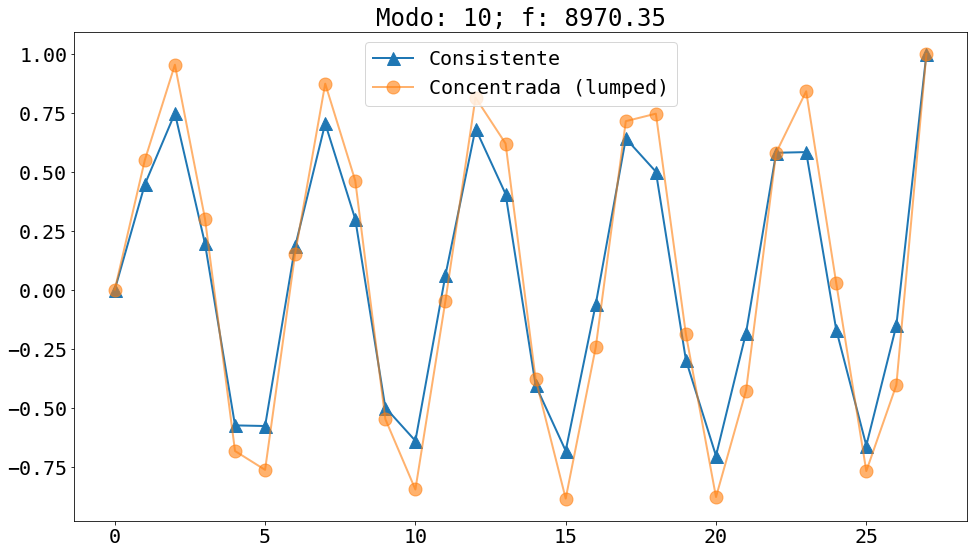

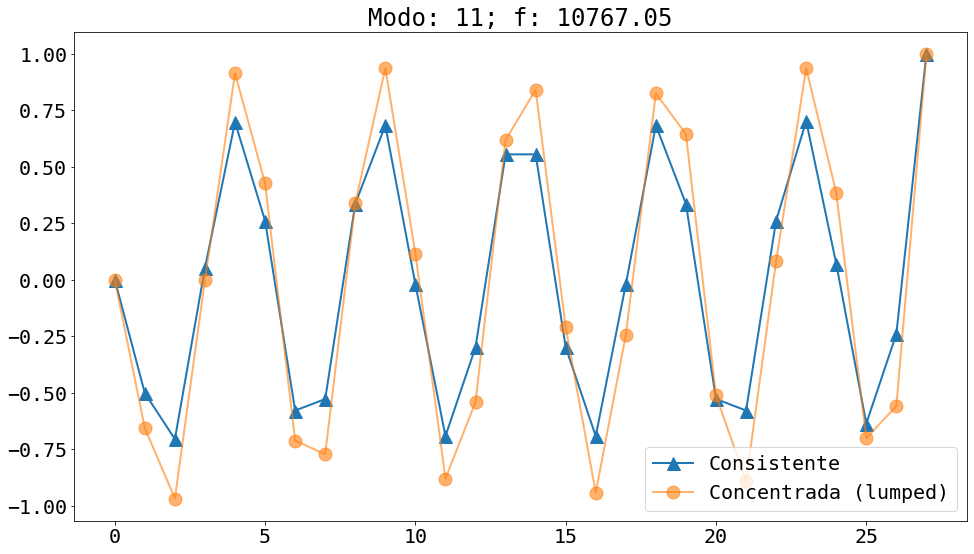

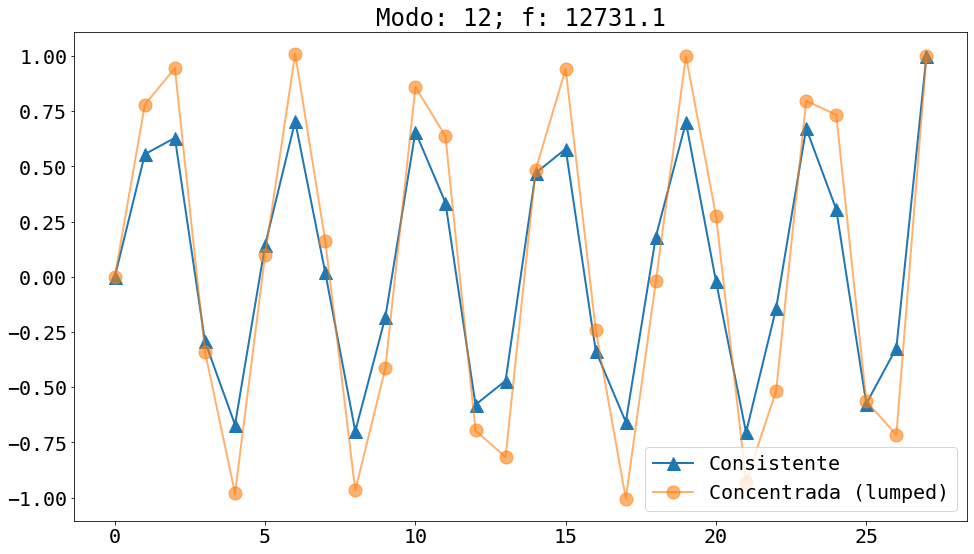

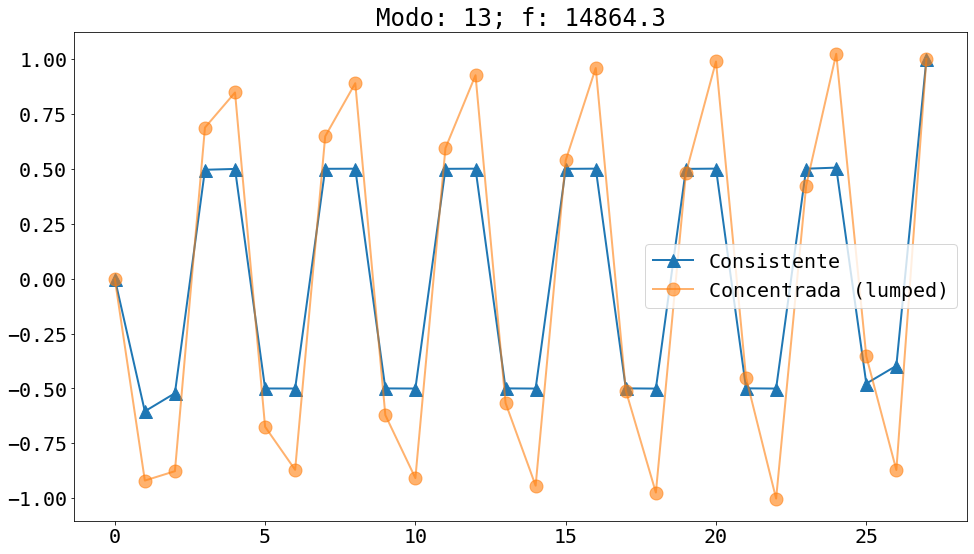

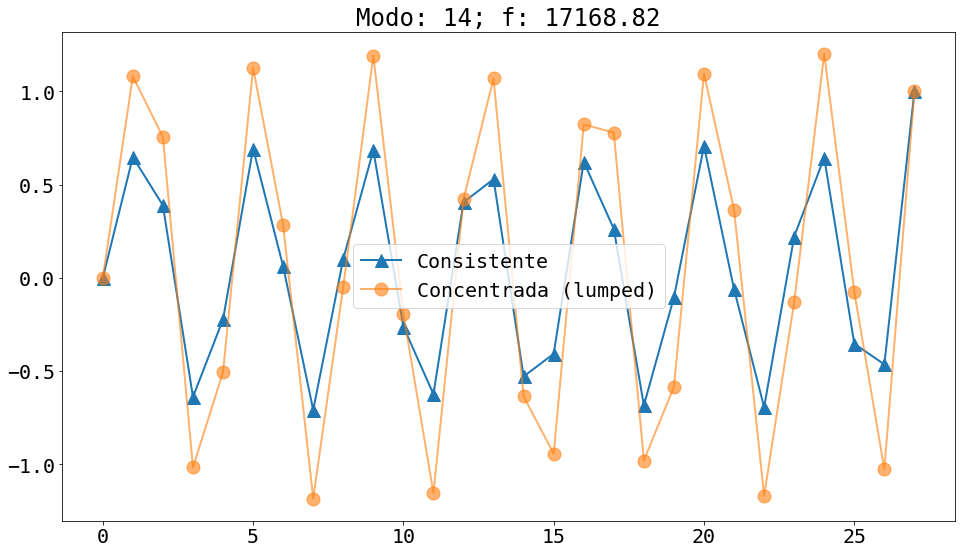

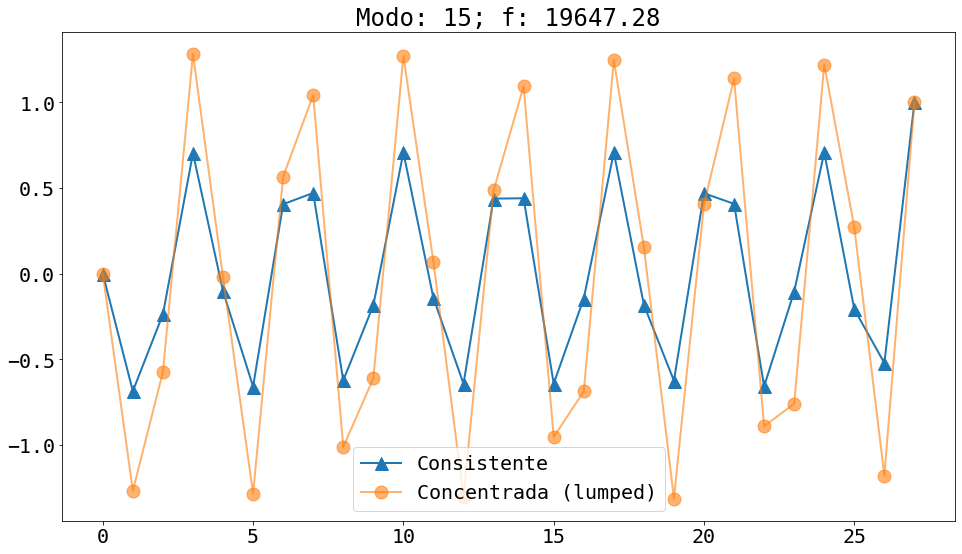

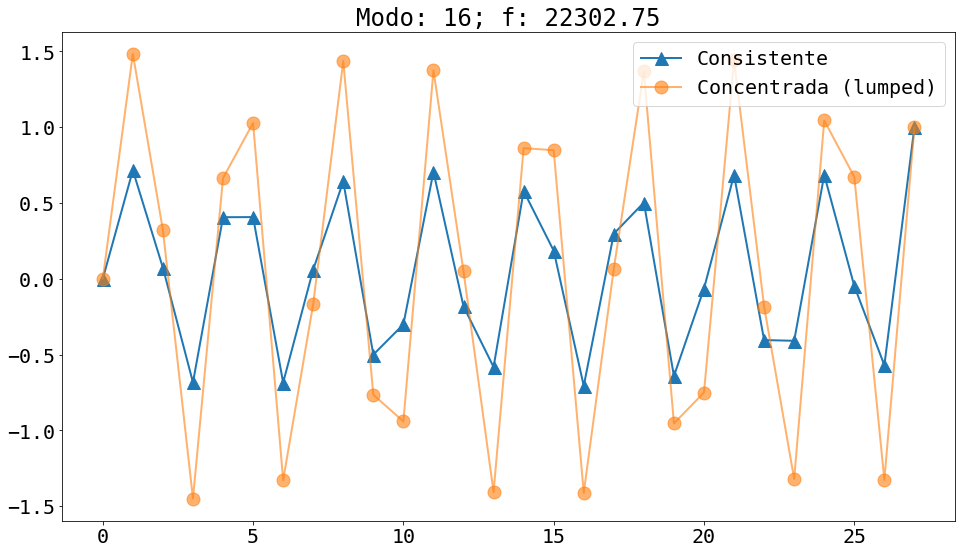

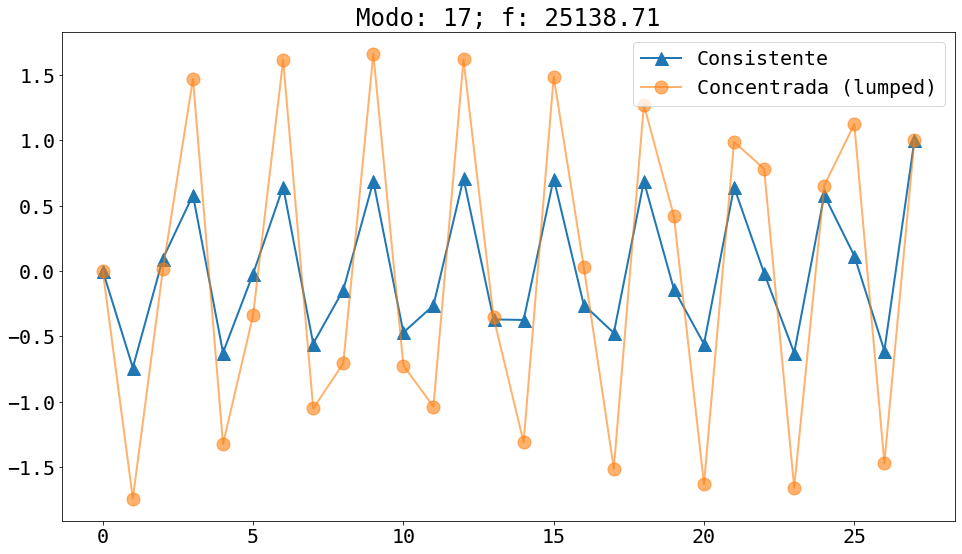

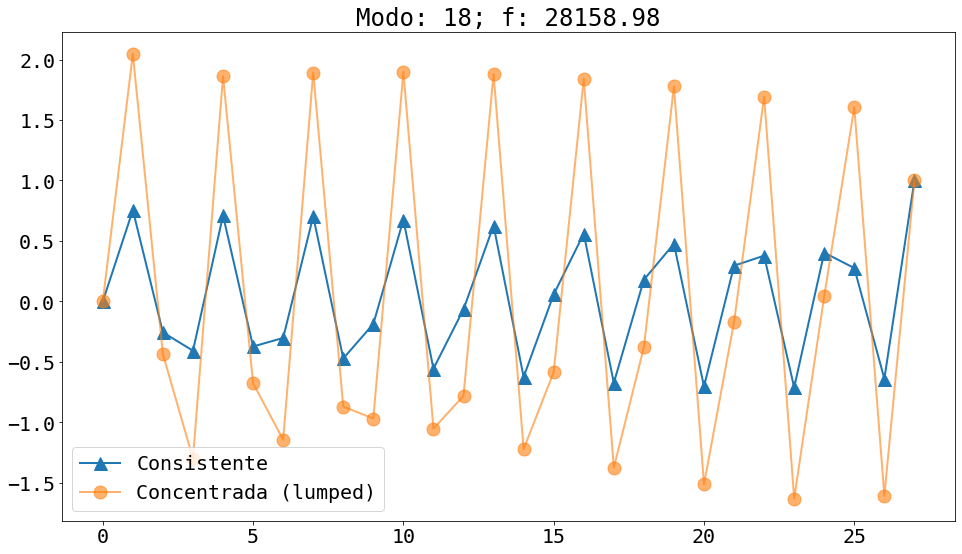

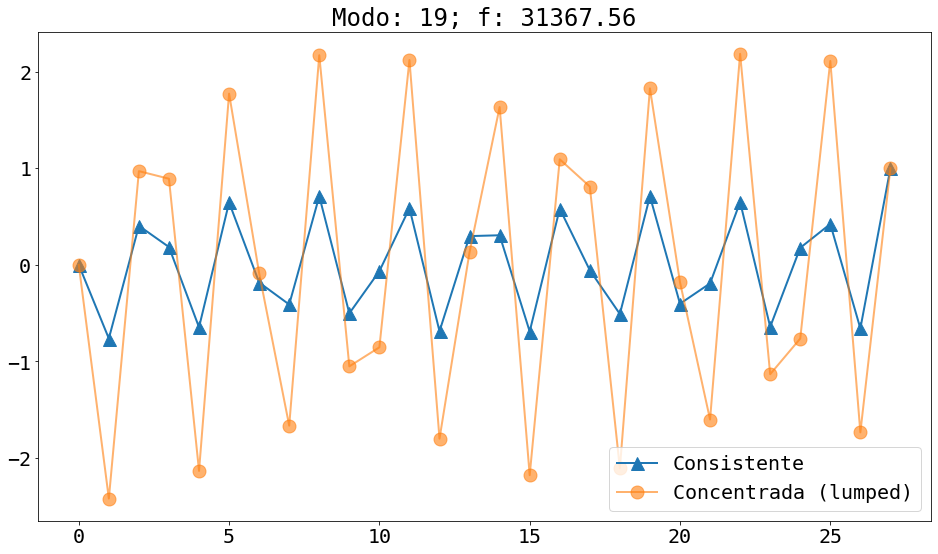

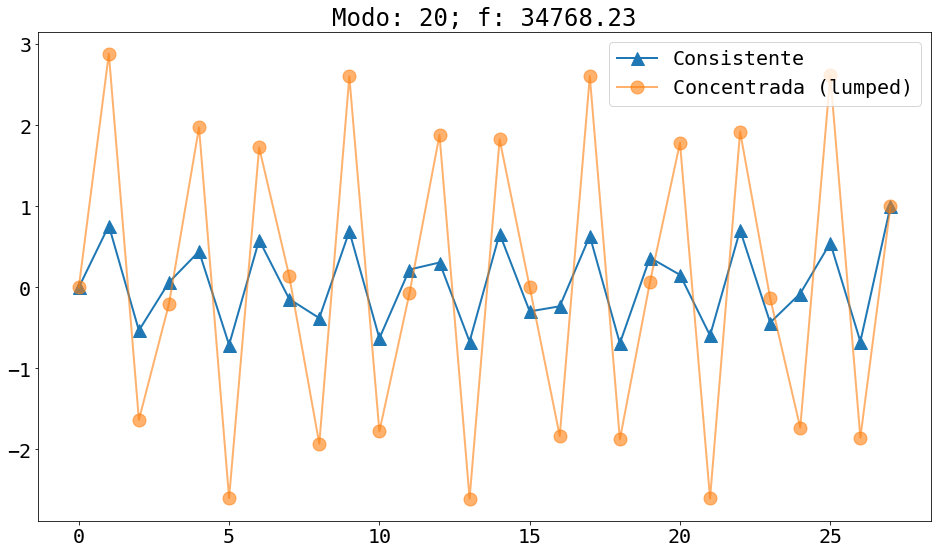

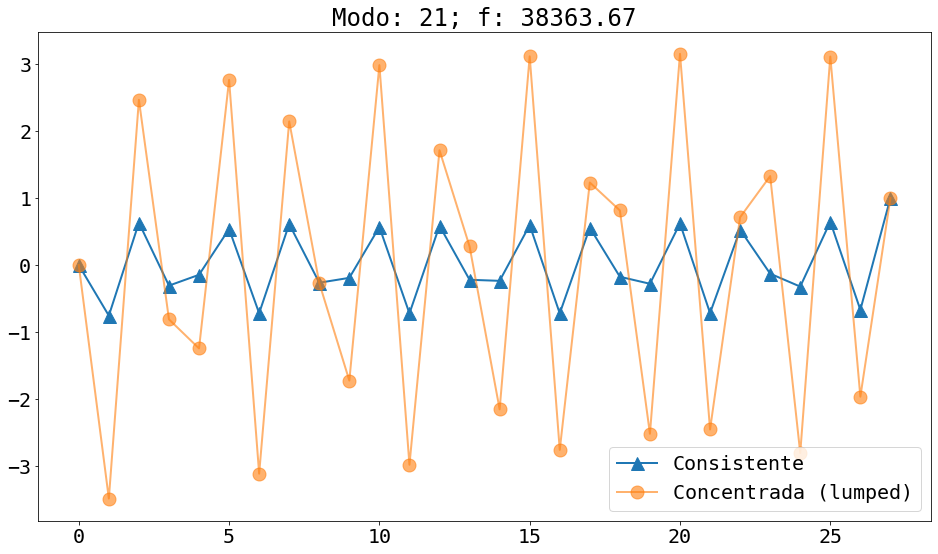

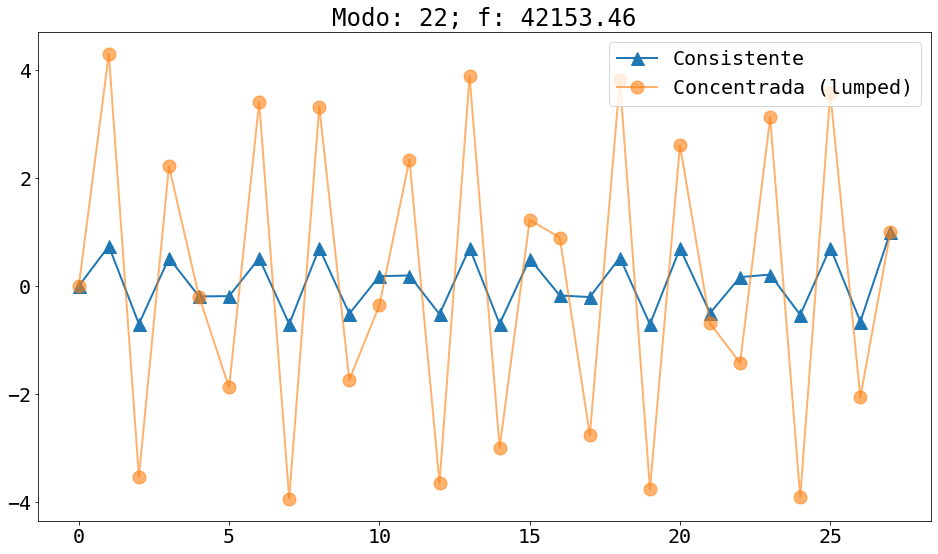

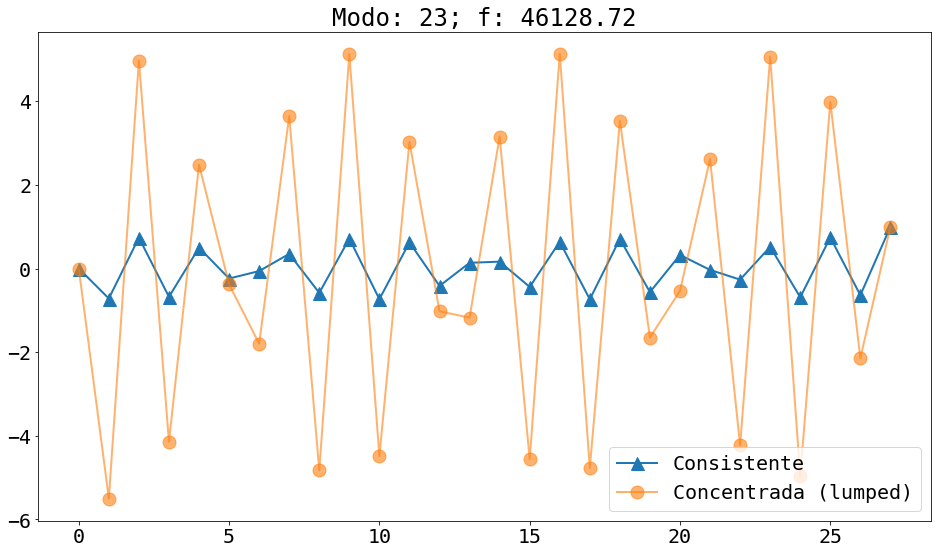

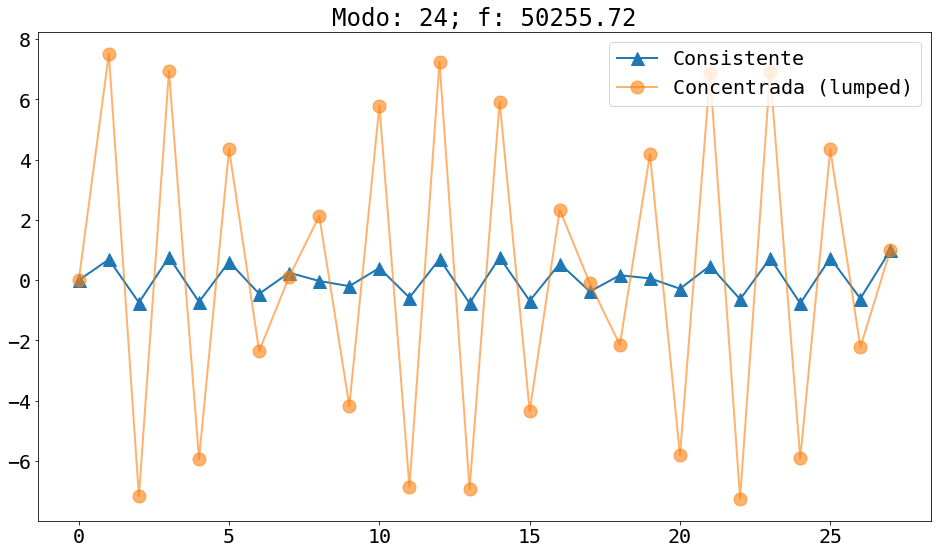

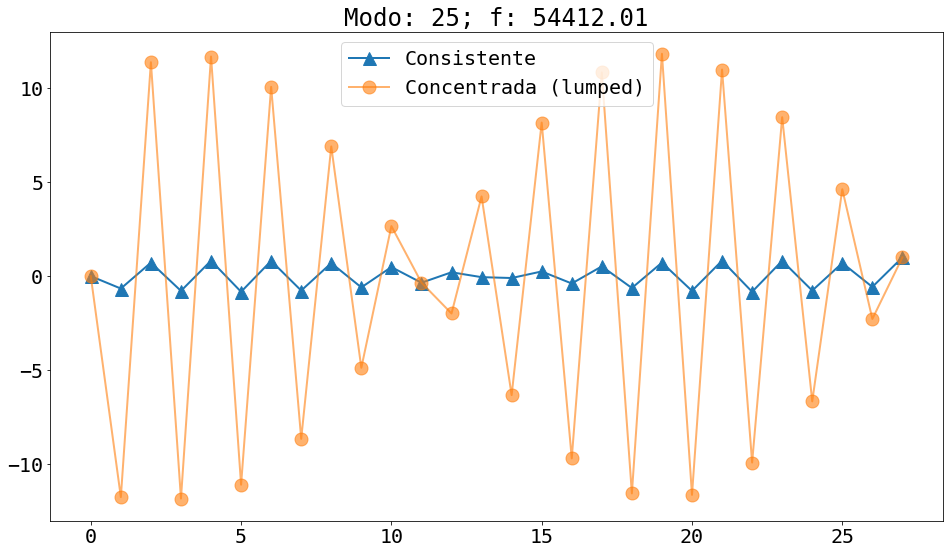

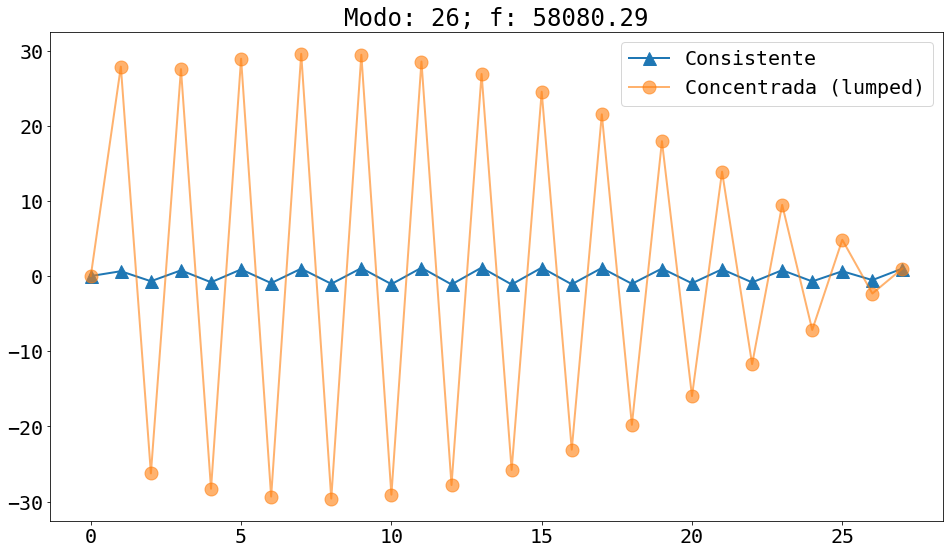

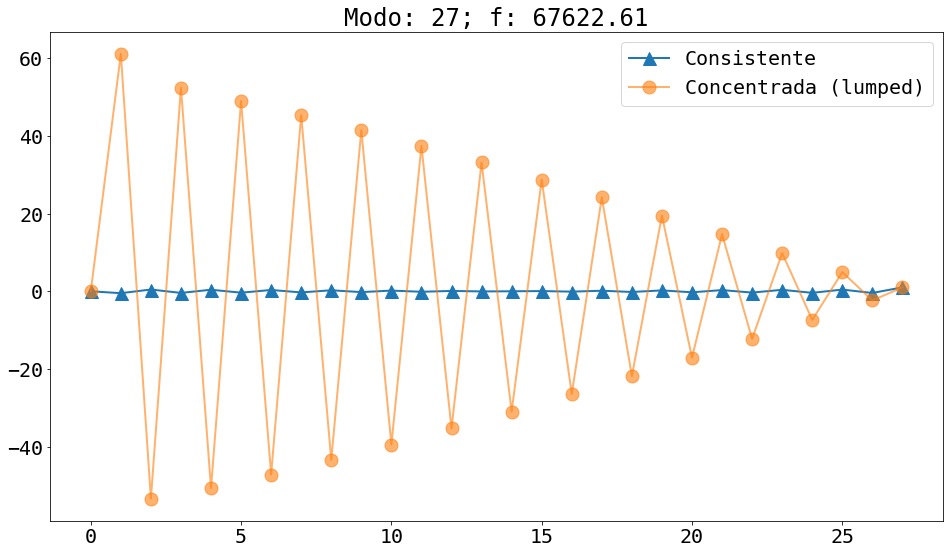

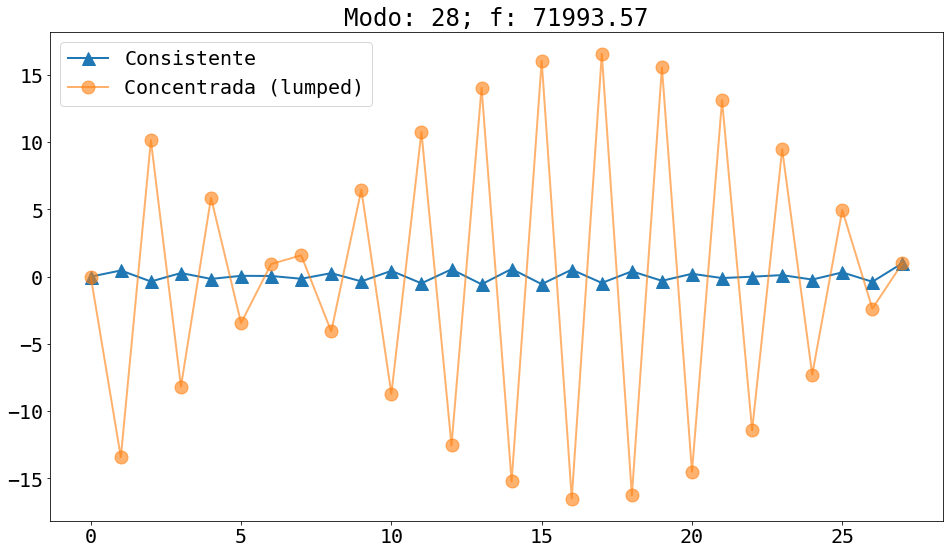

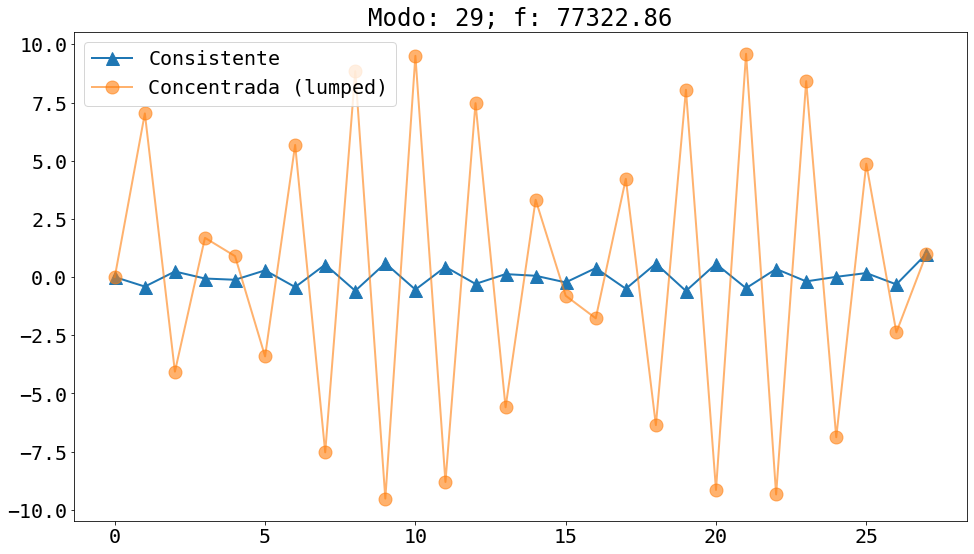

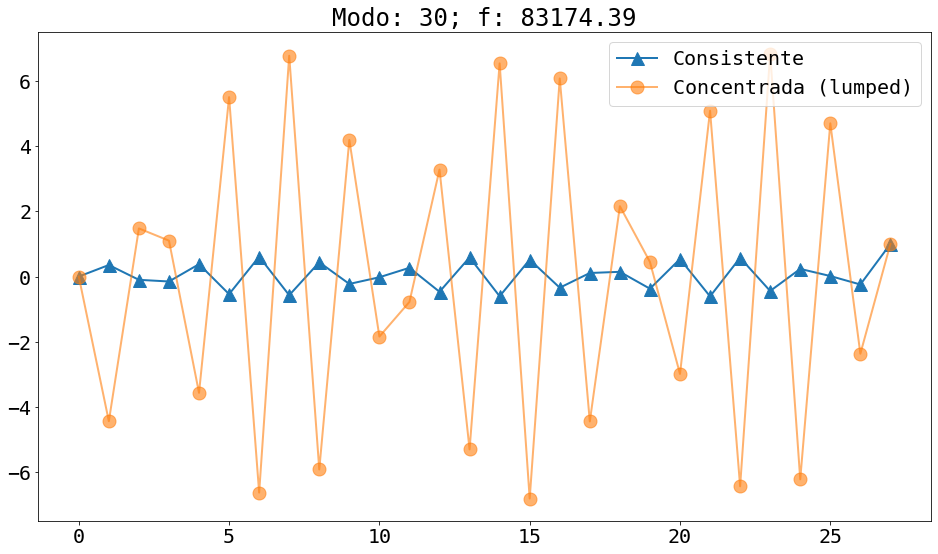

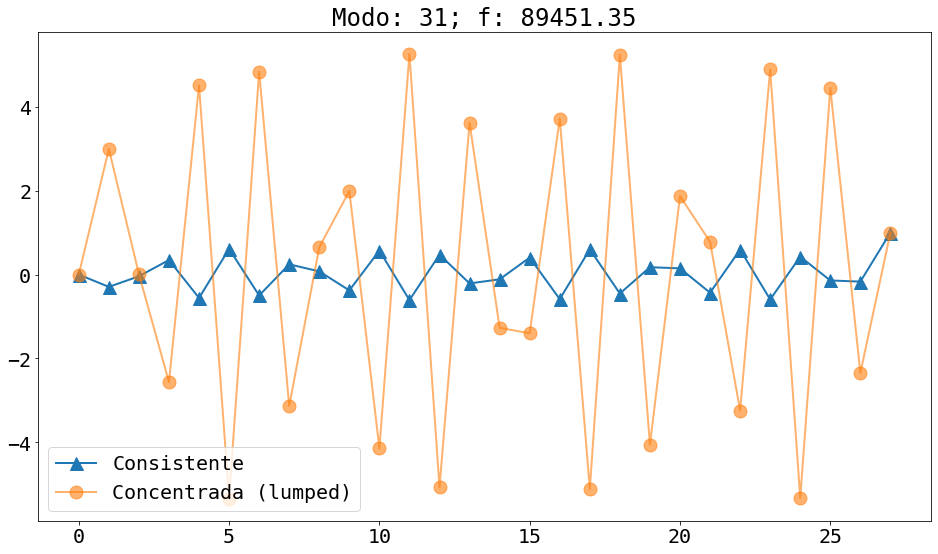

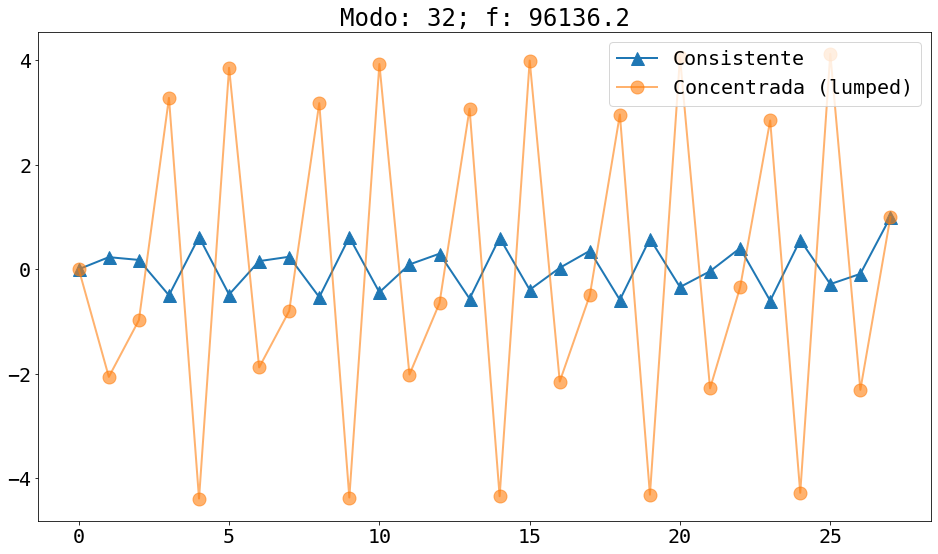

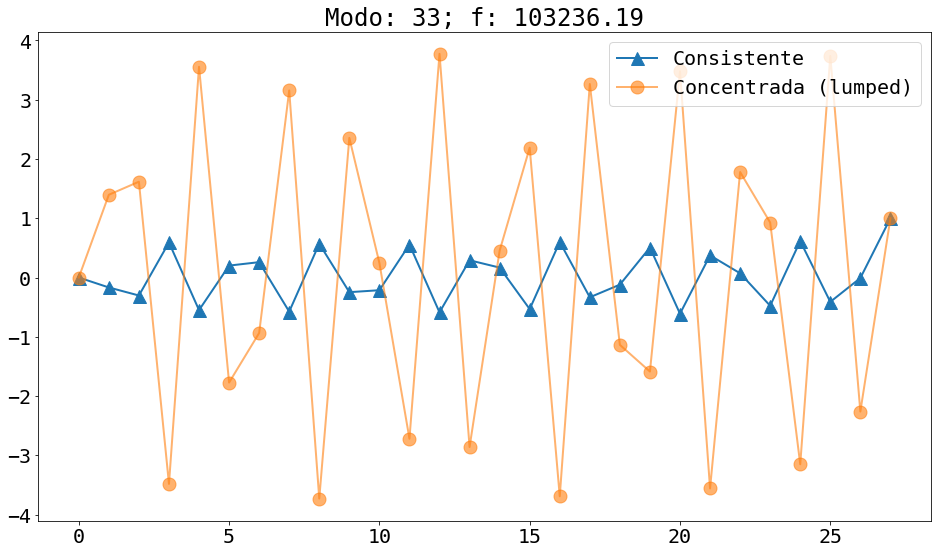

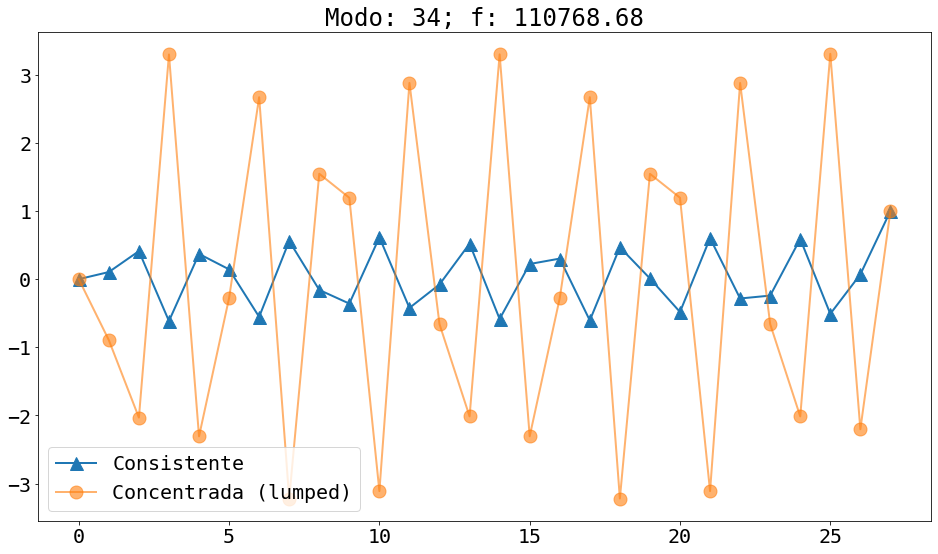

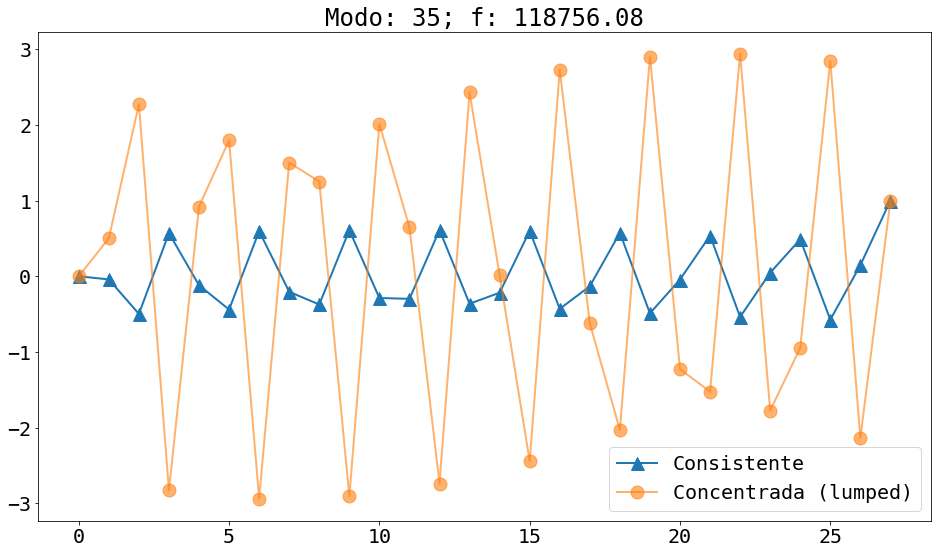

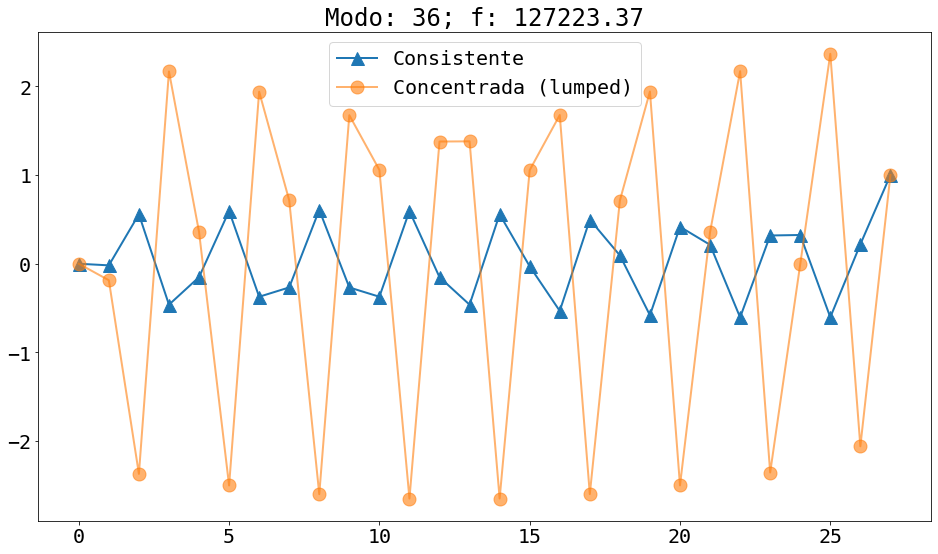

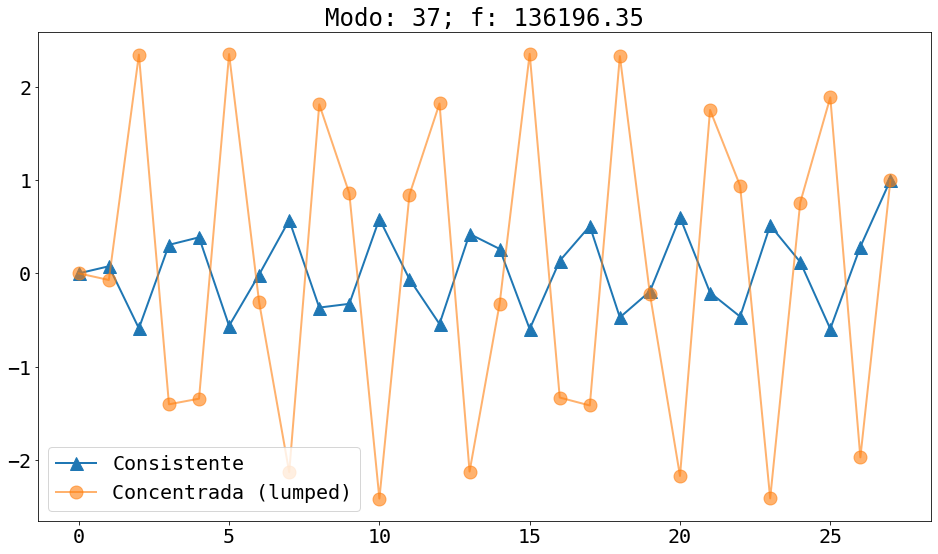

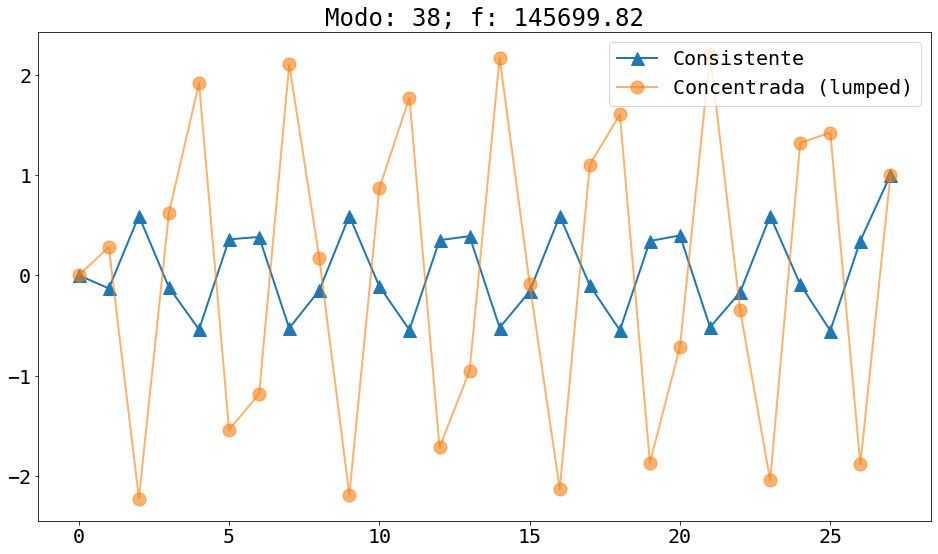

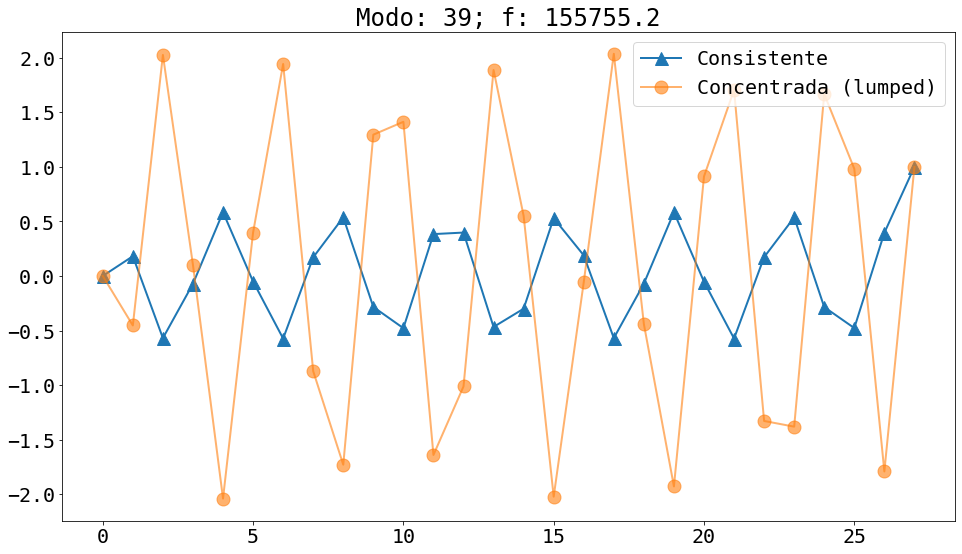

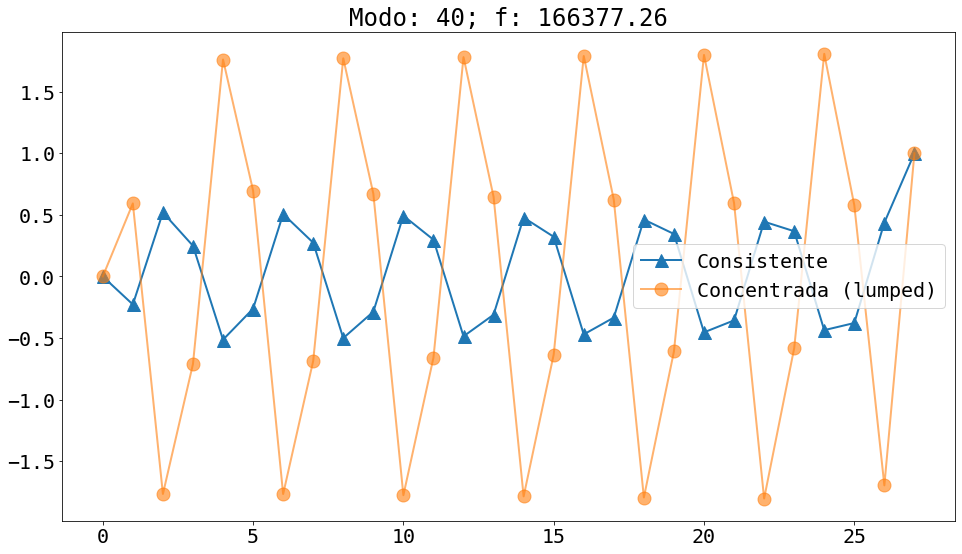

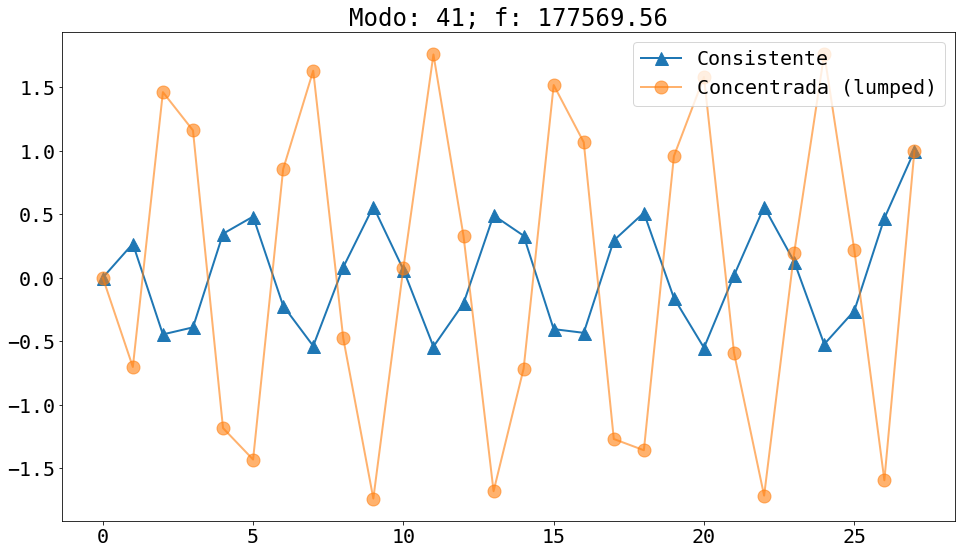

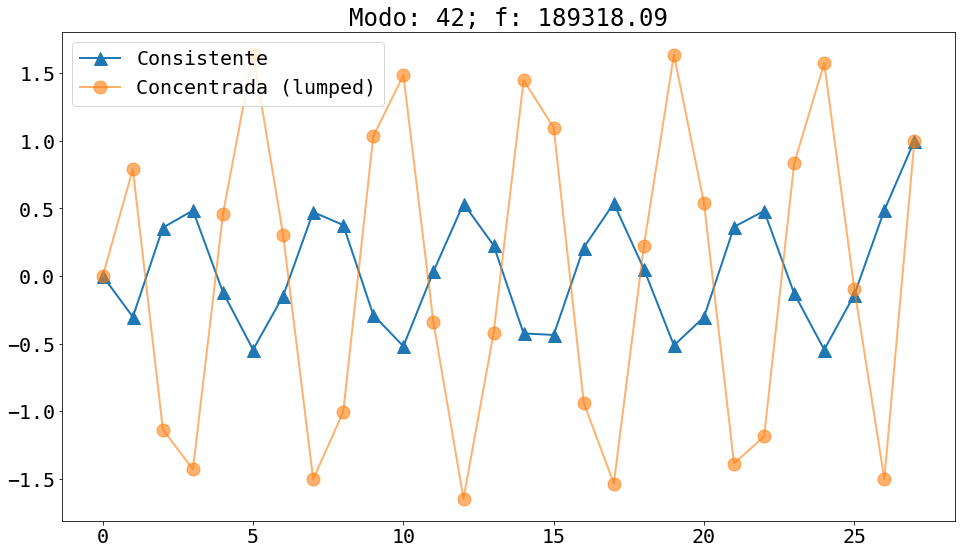

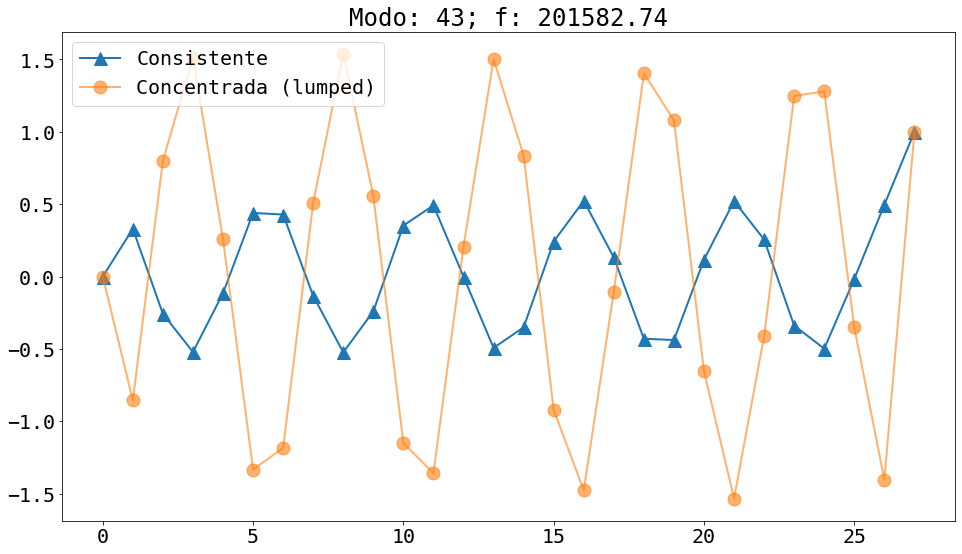

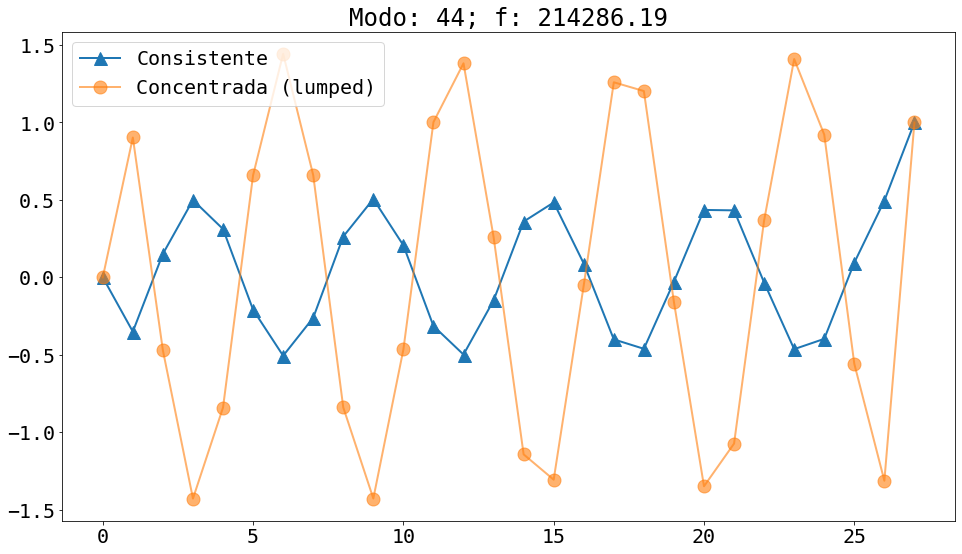

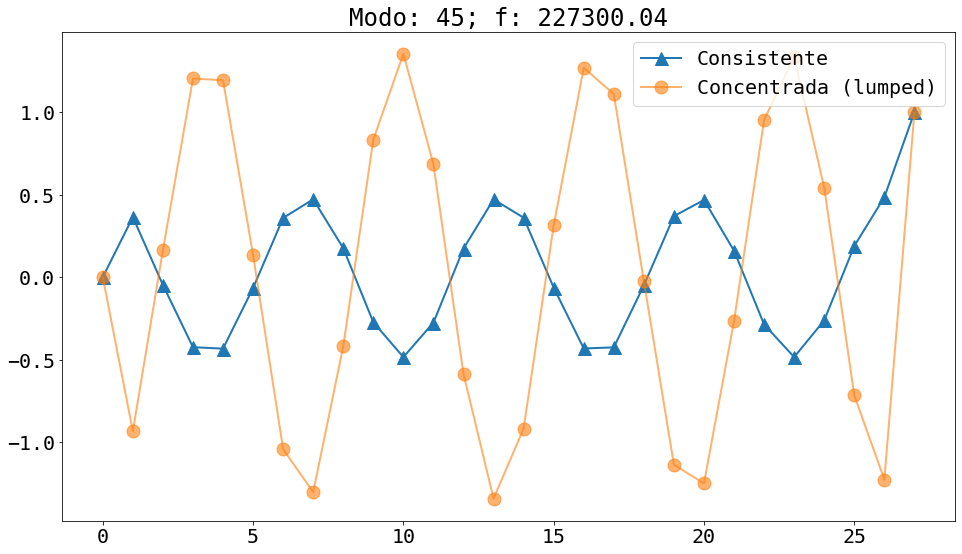

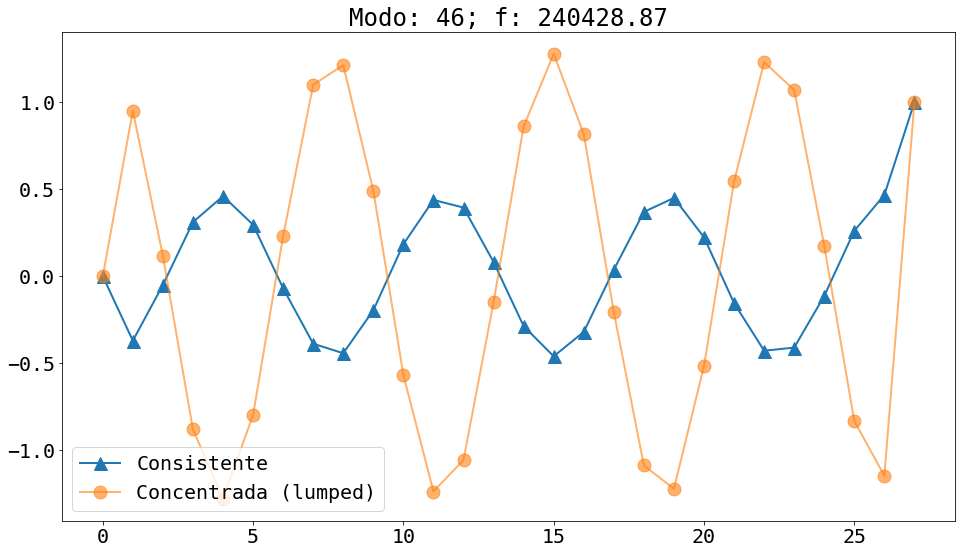

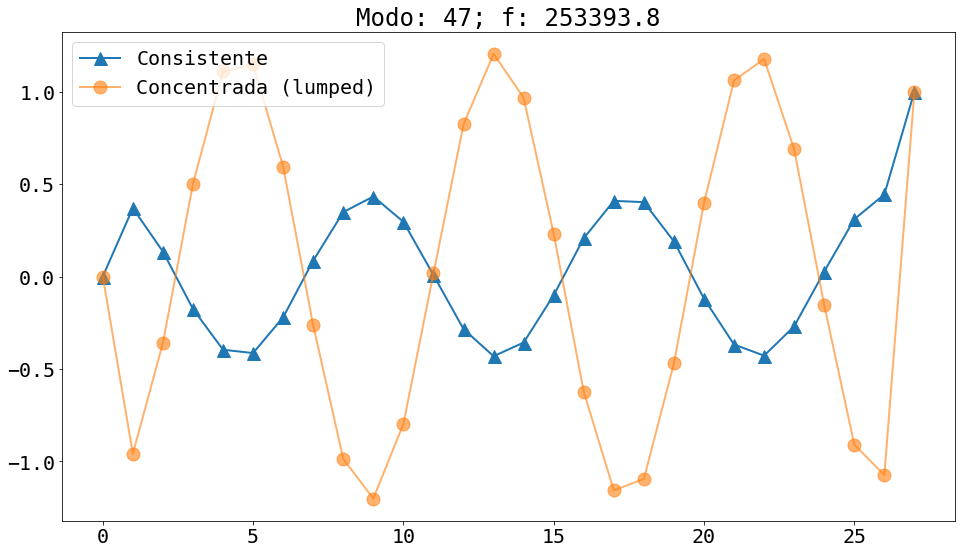

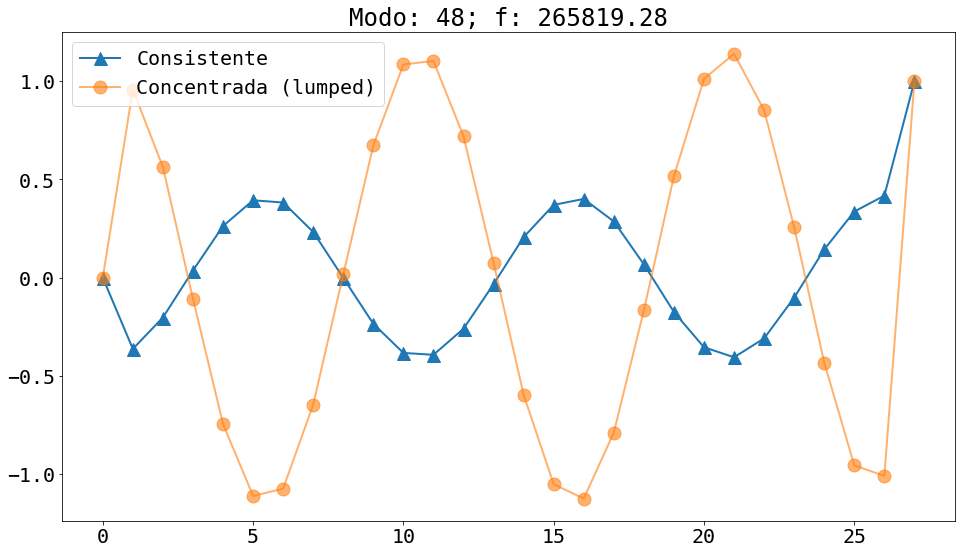

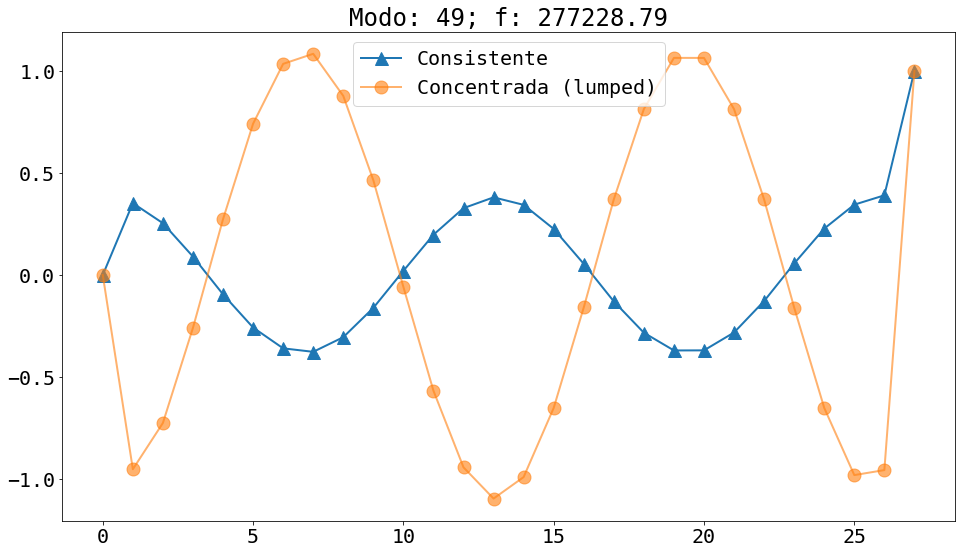

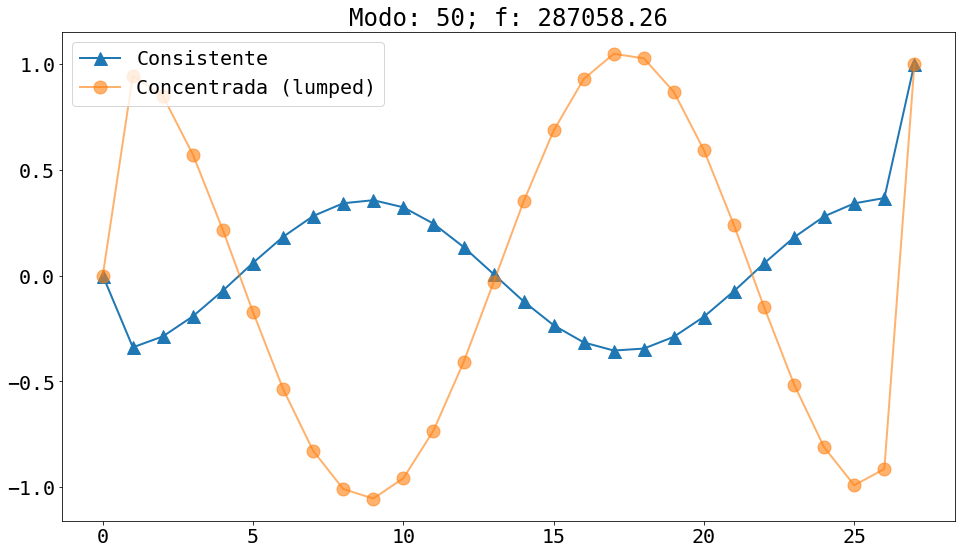

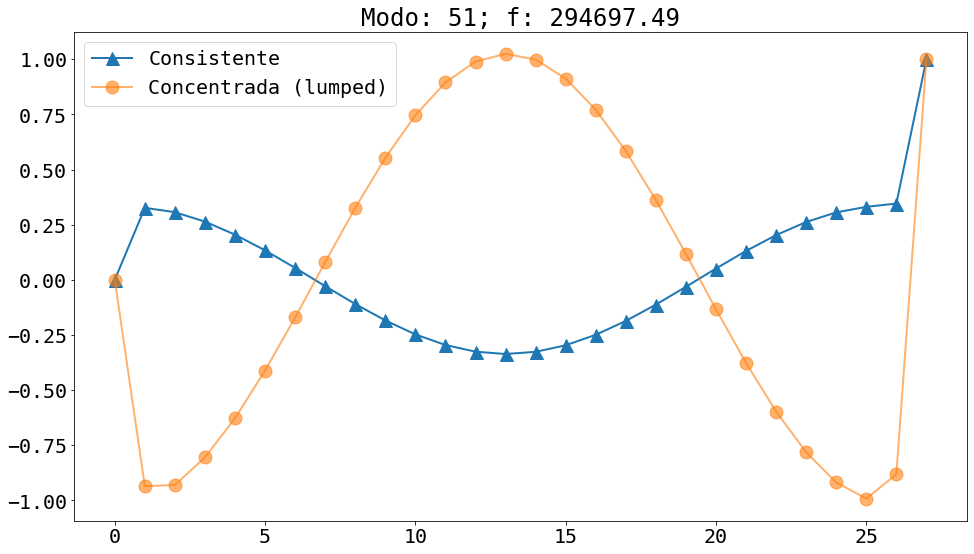

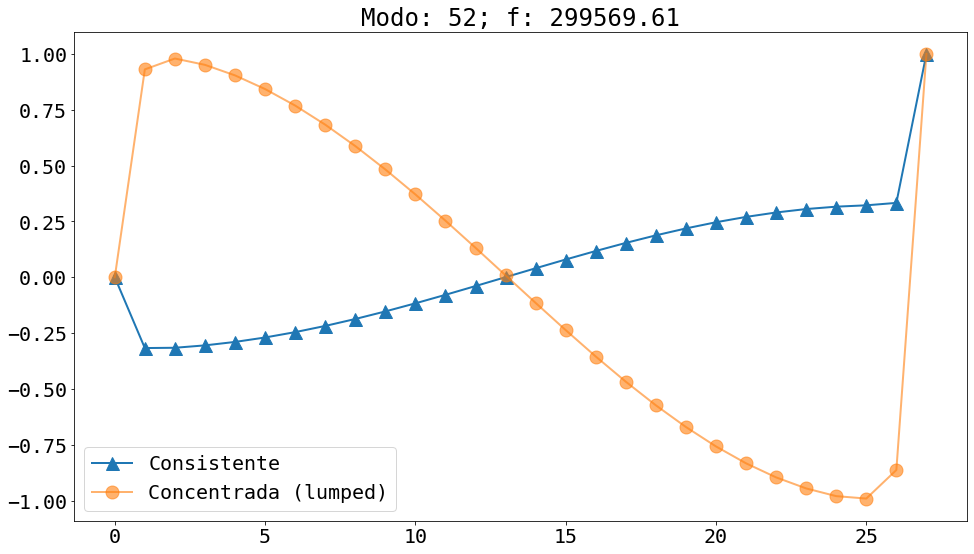

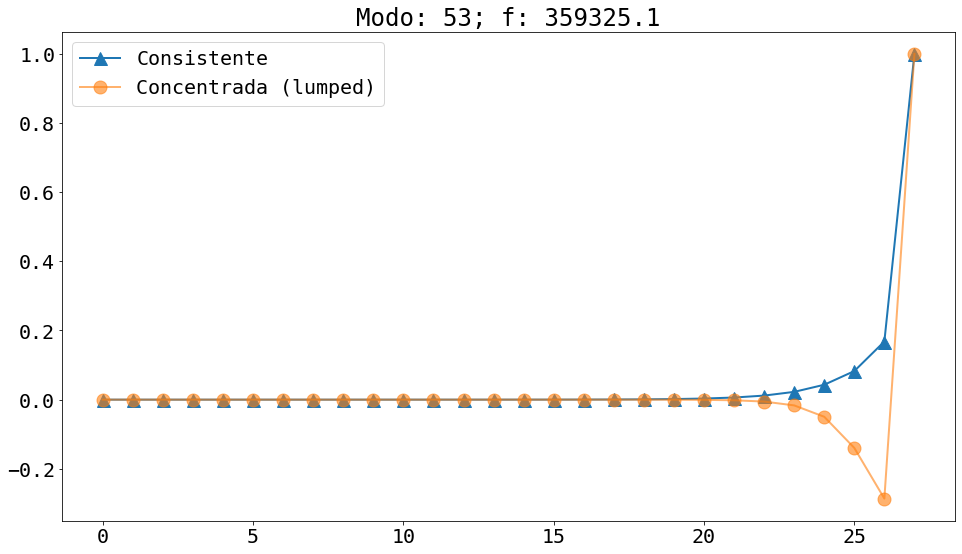

In [24]:
for i in range(len(f)):
    plt.figure()
    plt.title('Modo: ' + str(i) + '; f: '+ str(round(f[i], 2)))
    plt.plot(np.arange(Nn), d[:,i], '^-', label='Consistente')
    plt.plot(np.arange(Nn), d_c[:,i], 'o-', label='Concentrada (lumped)', alpha=0.6)
    plt.legend()

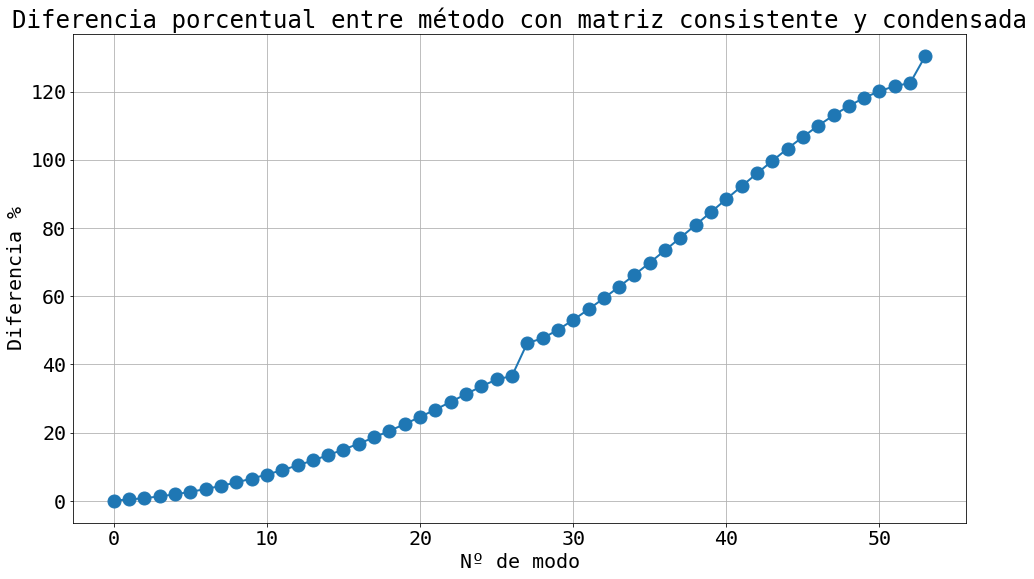

In [20]:
data = np.hstack([f.reshape(-1,1), f_c.reshape(-1,1)])
df = pandas.DataFrame(data, columns=['f', 'f_c'])
df['dif'] = f-f_c
df['e_r'] = df.dif/((f+f_c)/2)*100

fig, ax = plt.subplots()
ax.plot(df.index, df.e_r, 'o-')
ax.set_xlabel('Nº de modo')
ax.set_ylabel('Diferencia %')
ax.set_title('Diferencia porcentual entre método con matriz consistente y condensada')
plt.grid()